In [46]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
from tkinter import filedialog
from tkinter import *
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb

In [35]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')

In [3]:
root = Tk()
root.directory = filedialog.askdirectory()
print (root.directory)

C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data


In [4]:
param_dirs = os.listdir(root.directory)
param_dirs

['Act.xlsx',
 'ActTO.xlsx',
 'AveIII.xlsx',
 'Inact.xlsx',
 'InactTO.xlsx',
 'Lat1NP.xlsx']

In [5]:
dir_paths = []
for directory in param_dirs:
    path = root.directory + '/' + directory
    dir_paths.append(path)

dir_paths

['C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/Act.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/ActTO.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/AveIII.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/Inact.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/InactTO.xlsx',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Data/Lat1NP.xlsx']

In [6]:
animals = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Escl_groups.xlsx'
an_data = pd.read_excel(animals)
an_data = pd.DataFrame(data = an_data)
an_data.head()

,Animal,Group
0,2742,1
1,2743,1
2,2744,1
3,2752,1
4,2773,1


In [7]:
def ShA_param_summary(data, param_name):
    summary_full = pd.DataFrame()
    summary_ave = pd.DataFrame()
    summary_last = pd.DataFrame()
    
    for index, row in data.iterrows():
    
        animal = row[0]
        train_len = len(row.dropna()) - 1
        first = row.values[1]
        SA_1, SA_2, SA_3, SA_4, SA_5 = row.dropna().values[-5:]
        ave = (SA_1 + SA_2 + SA_3 + SA_4 + SA_5) / 5
    
        int_sum_full = pd.DataFrame(data = [animal, train_len, first, ave, SA_1, SA_2, SA_3, SA_4, SA_5]).T
        int_sum_full.columns = ['Animal', 'tl', param_name.lower() + '_1st', param_name.lower() + '_ave', param_name.lower() + '_1SA', param_name.lower() + '_2SA', param_name.lower() + '_3SA', param_name.lower() + '_4SA', param_name.lower() + '_5SA']
        summary_full = pd.concat([summary_full, int_sum_full], axis = 0, ignore_index=True)

        int_sum_ave = pd.DataFrame(data = [animal, train_len, first, ave]).T
        int_sum_ave.columns = ['Animal', 'tl', param_name.lower() + '_1st', param_name.lower() + '_ave']
        summary_ave = pd.concat([summary_ave, int_sum_ave], axis = 0, ignore_index=True)
        
        int_sum_last = pd.DataFrame(data = [animal, train_len, first, SA_5]).T
        int_sum_last.columns = ['Animal', 'tl', param_name.lower() + '_1st', param_name.lower() + '_5SA']
        summary_last = pd.concat([summary_last, int_sum_last], axis = 0, ignore_index=True)
        
    return summary_full, summary_ave, summary_last

In [13]:
summary_full = pd.DataFrame()
summary_ave = pd.DataFrame()
summary_last = pd.DataFrame()

for path in dir_paths:
    data = pd.read_excel(path)
    df = pd.DataFrame(data = data)
    param = path.split('/')[-1].split('.')[0]
    
    int_summary_full, int_summary_ave, int_summary_last = ShA_param_summary(df, param)
    
    summary_full = pd.concat([summary_full, int_summary_full, an_data], axis = 1)
    summary_full = summary_full.loc[:,~summary_full.columns.duplicated()]
    
    summary_ave = pd.concat([summary_ave, int_summary_ave, an_data], axis = 1)
    summary_ave = summary_ave.loc[:,~summary_ave.columns.duplicated()]
    
    summary_last = pd.concat([summary_last, int_summary_last, an_data], axis = 1)
    summary_last = summary_last.loc[:,~summary_last.columns.duplicated()]

print(summary_full.shape)
print(summary_ave.shape)
print(summary_last.shape)

summary_ave.head()

(32, 45)
(32, 15)
(32, 15)


,Animal,tl,act_1st,act_ave,Group,actto_1st,actto_ave,aveiii_1st,aveiii_ave,inact_1st,inact_ave,inactto_1st,inactto_ave,lat1np_1st,lat1np_ave
0,2742.0,11.0,7.0,14.8,1,8.0,2.2,487.338333,243.018585,5.0,1.6,0.0,0.0,50.88,76.672
1,2743.0,12.0,8.0,26.8,1,19.0,3.8,480.884286,138.283893,5.0,0.4,9.0,0.0,14.33,15.368
2,2744.0,11.0,5.0,22.2,1,9.0,11.2,684.822500,163.706254,11.0,4.0,1.0,2.2,30.16,10.524
3,2752.0,13.0,3.0,11.8,1,1.0,6.0,821.565000,386.589657,0.0,0.4,0.0,0.0,8.19,68.142
4,2773.0,16.0,3.0,22.4,1,12.0,12.2,1494.605000,179.103978,10.0,2.0,0.0,0.8,489.34,47.644


Visualization

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


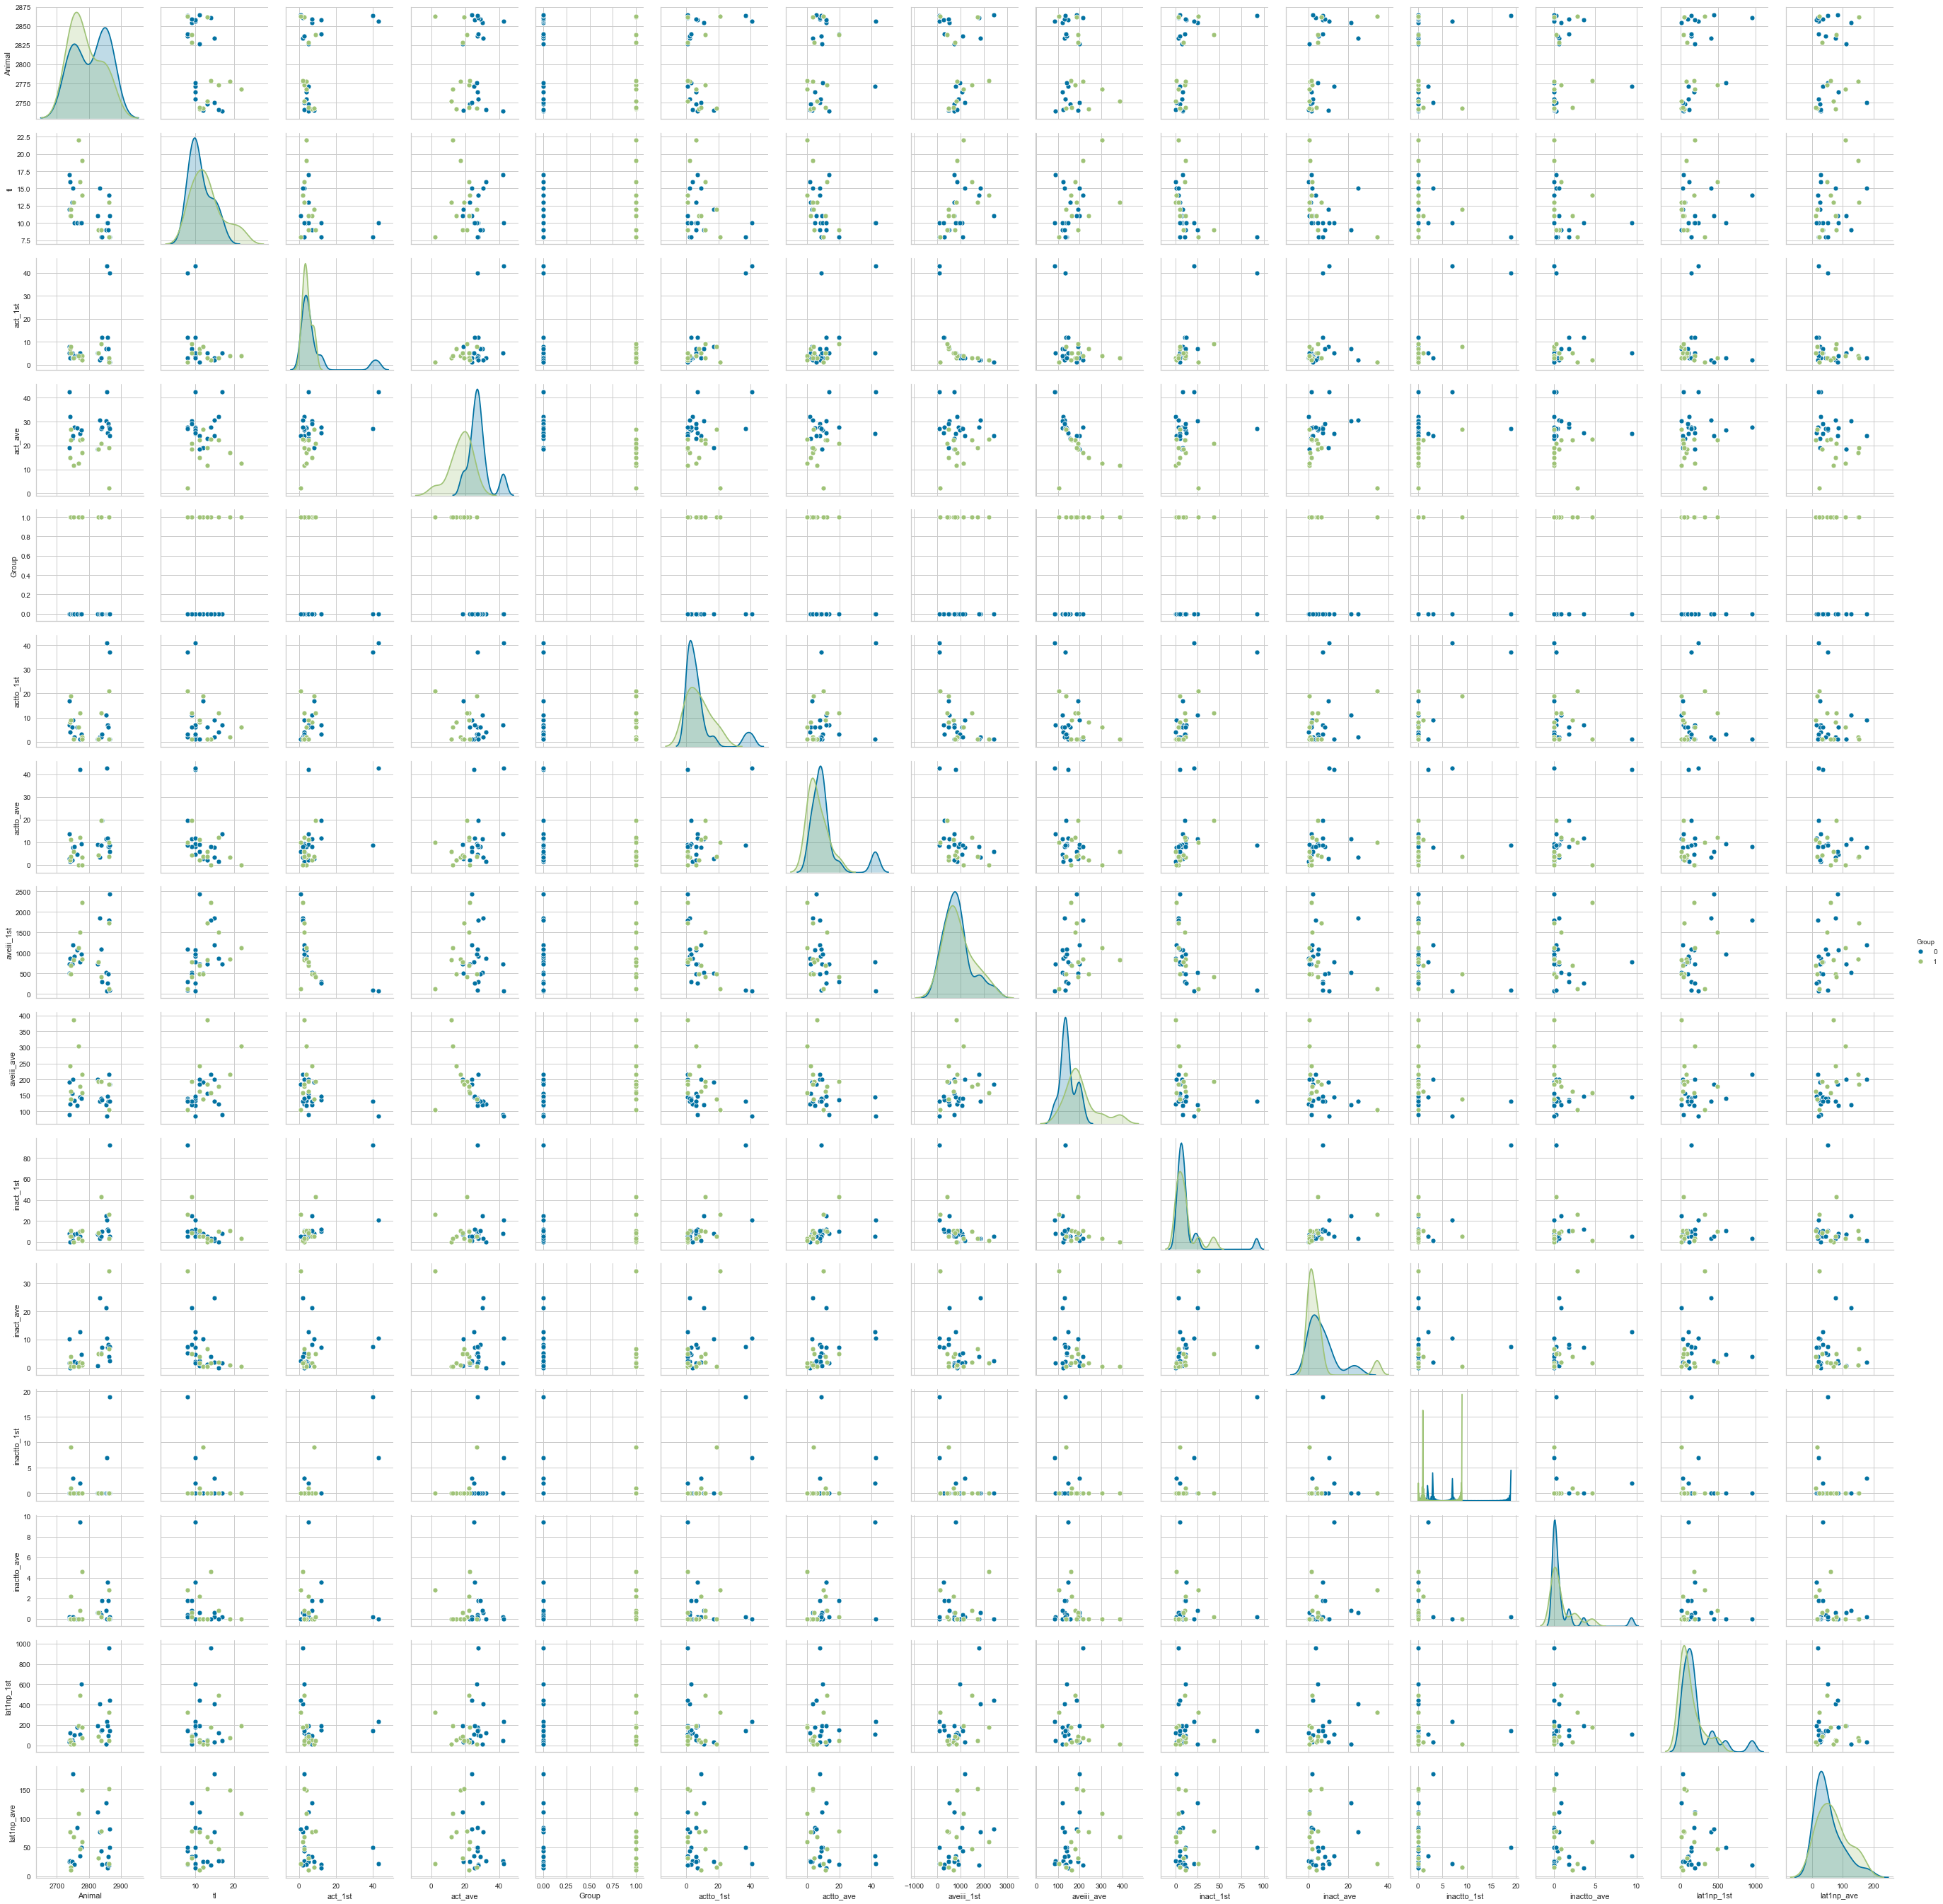

In [14]:
sns.pairplot(summary_ave, hue = 'Group')

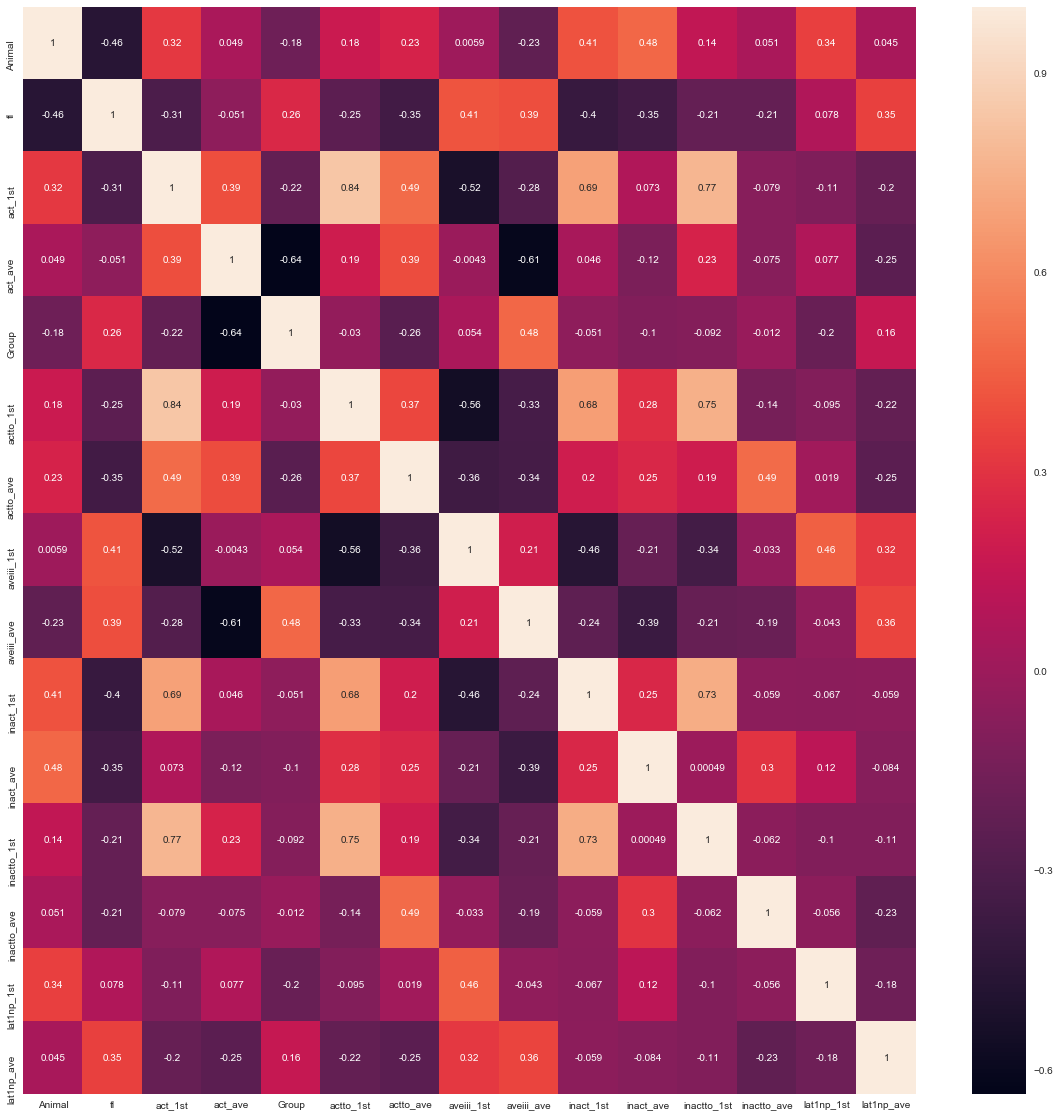

In [15]:
corr = summary_ave.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True)

Z-score normalize


Correct for skewed features?


Missing data?


In [16]:
summary_ave.columns.values

array(['Animal', 'tl', 'act_1st', 'act_ave', 'Group', 'actto_1st',
       'actto_ave', 'aveiii_1st', 'aveiii_ave', 'inact_1st', 'inact_ave',
       'inactto_1st', 'inactto_ave', 'lat1np_1st', 'lat1np_ave'],
      dtype=object)

In [18]:
ave_features = summary_ave[['tl', 'act_ave', 'actto_ave', 'aveiii_ave', 'inact_ave', 'inactto_ave', 'lat1np_ave']]
ave_labels = summary_ave['Group']

In [108]:
# center and scale the data
scaler = StandardScaler()

ave_features_scaled = scaler.fit_transform(ave_features)

X_train, X_test, y_train, y_test = train_test_split(ave_features_scaled, ave_labels, test_size = .3, random_state=1234)

In [118]:
strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(X_train, y_train))

In [119]:
dm_cv = DummyClassifier(strategy='stratified', random_state=0)
lr_cv = LogisticRegression(random_state=0)
rf_cv = RandomForestClassifier(max_depth=3, random_state=0)
svm_cv = SVC(probability=True) 
kn_cv = KNeighborsClassifier(n_neighbors=1)

In [126]:
y_pred_dm = cross_val_predict(dm_cv, X_train, y_train, cv=cv, method='predict')
y_pred_prob_dm = cross_val_predict(dm_cv, X_train, y_train, cv=cv, method='predict_proba')
conf_mat_dm = confusion_matrix(y_train, y_pred_dm)
conf_mat_dm

array([[14,  2],
       [ 6,  0]], dtype=int64)

In [121]:
y_pred_lr = cross_val_predict(lr_cv, X_train, y_train, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, X_train, y_train, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(y_train, y_pred_lr)
conf_mat_lr

array([[15,  1],
       [ 2,  4]], dtype=int64)

In [122]:
y_pred_rf = cross_val_predict(rf_cv, X_train, y_train, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, X_train, y_train, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(y_train, y_pred_rf)
conf_mat_rf

array([[16,  0],
       [ 4,  2]], dtype=int64)

In [123]:
y_pred_svm = cross_val_predict(svm_cv, X_train, y_train, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, X_train, y_train, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(y_train, y_pred_svm)
conf_mat_svm

array([[16,  0],
       [ 5,  1]], dtype=int64)

In [124]:
y_pred_kn = cross_val_predict(kn_cv, X_train, y_train, cv=cv, method='predict')
y_pred_prob_kn = cross_val_predict(kn_cv, X_train, y_train, cv=cv, method='predict_proba')
conf_mat_kn = confusion_matrix(y_train, y_pred_kn)
conf_mat_kn

array([[15,  1],
       [ 4,  2]], dtype=int64)

In [125]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_train,y_pred_dm))
print("Precision (PPV): ", metrics.precision_score(y_train,y_pred_dm))
print("Accuracy: ", metrics.accuracy_score(y_train,y_pred_dm))
print("F1:", metrics.f1_score(y_train,y_pred_dm))

Sensitivity/Recall (TPR):  0.0
Precision (PPV):  0.0
Accuracy:  0.6363636363636364
F1: 0.0


In [127]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_train,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(y_train,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(y_train,y_pred_lr))
print("F1:", metrics.f1_score(y_train,y_pred_lr))

Sensitivity/Recall (TPR):  0.6666666666666666
Precision (PPV):  0.8
Accuracy:  0.8636363636363636
F1: 0.7272727272727272


In [128]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_train,y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(y_train,y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(y_train,y_pred_rf))
print("F1:", metrics.f1_score(y_train,y_pred_rf))

Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  1.0
Accuracy:  0.8181818181818182
F1: 0.5


In [129]:
print("Dummy ROC_AUC: ", metrics.roc_auc_score(y_train, y_pred_prob_dm[:,1]))
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(y_train, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(y_train, y_pred_prob_rf[:,1]))

Logistic regression ROC_AUC:  0.4375
Logistic regression ROC_AUC:  0.8541666666666667
Random forest ROC_AUC:  0.7291666666666666


Text(0,0.5,'True Positive Rate (Sensitivity)')

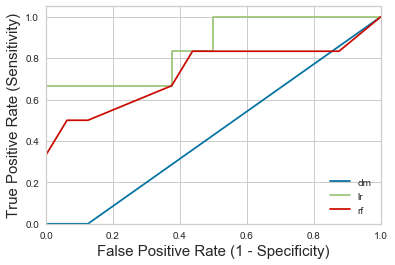

In [130]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(y_train, y_pred_prob_dm[:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_train, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_train, y_pred_prob_rf[:,1])

# plot LR model ROC curves
plt.plot(fpr_dm, tpr_dm,label="dm")
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0,0.5,'Precision')

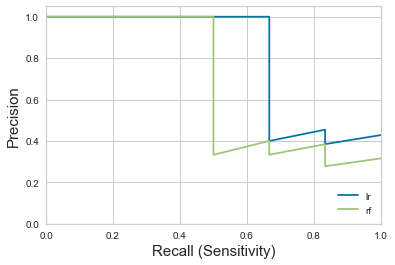

In [76]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(y_train, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(y_train, y_pred_prob_rf[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [80]:
fi = pd.DataFrame({'feature': list(ave_features.columns),
                   'importance': lr_cv.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [9]:
df_features_full = summary_full.drop(['Group', 'Animal'], axis = 1)
df_feat_names_full = df_features_full.columns.values
print(df_feat_names_full)
df_features_ave = summary_ave.drop(['Group', 'Animal'], axis = 1)
df_feat_names_ave = df_features_ave.columns.values
print(df_feat_names_ave)
df_features_last = summary_last.drop(['Group', 'Animal'], axis = 1)
df_feat_names_last = df_features_last.columns.values
print(df_feat_names_last)
df_classes = summary_ave.Group

['tl' 'act_1st' 'act_ave' 'act_1SA' 'act_2SA' 'act_3SA' 'act_4SA'
 'act_5SA' 'actto_1st' 'actto_ave' 'actto_1SA' 'actto_2SA' 'actto_3SA'
 'actto_4SA' 'actto_5SA' 'aveiii_1st' 'aveiii_ave' 'aveiii_1SA'
 'aveiii_2SA' 'aveiii_3SA' 'aveiii_4SA' 'aveiii_5SA' 'inact_1st'
 'inact_ave' 'inact_1SA' 'inact_2SA' 'inact_3SA' 'inact_4SA' 'inact_5SA'
 'inactto_1st' 'inactto_ave' 'inactto_1SA' 'inactto_2SA' 'inactto_3SA'
 'inactto_4SA' 'inactto_5SA' 'lat1np_1st' 'lat1np_ave' 'lat1np_1SA'
 'lat1np_2SA' 'lat1np_3SA' 'lat1np_4SA' 'lat1np_5SA']
['tl' 'act_1st' 'act_ave' 'actto_1st' 'actto_ave' 'aveiii_1st'
 'aveiii_ave' 'inact_1st' 'inact_ave' 'inactto_1st' 'inactto_ave'
 'lat1np_1st' 'lat1np_ave']
['tl' 'act_1st' 'act_5SA' 'actto_1st' 'actto_5SA' 'aveiii_1st'
 'aveiii_5SA' 'inact_1st' 'inact_5SA' 'inactto_1st' 'inactto_5SA'
 'lat1np_1st' 'lat1np_5SA']


In [10]:
# center and scale the data
scaler = StandardScaler()
data_scaled_full = scaler.fit_transform(df_features_full)
data_scaled_full = pd.DataFrame(data_scaled_full,columns=df_features_full.columns.values)
data_scaled_ave = scaler.fit_transform(df_features_ave)
data_scaled_ave = pd.DataFrame(data_scaled_ave,columns=df_features_ave.columns.values)
data_scaled_last = scaler.fit_transform(df_features_last)
data_scaled_last = pd.DataFrame(data_scaled_last,columns=df_features_last.columns.values)

K means clustering

Text(0,0.5,'Silhouette Coefficient')

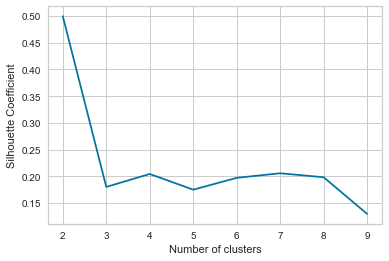

In [12]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(data_scaled_ave)
    scores.append(silhouette_score(data_scaled_ave, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [13]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(data_scaled_ave)
summary_ave['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
summary_ave.groupby('kmeans_2_scaled').mean()

,Animal,tl,act_1st,act_ave,Group,actto_1st,actto_ave,aveiii_1st,aveiii_ave,inact_1st,inact_ave,inactto_1st,inactto_ave,lat1np_1st,lat1np_ave
kmeans_2_scaled,,,,,,,,,,,,,,,
cluster_0,2796.366667,12.166667,4.833333,23.28,0.4,6.066667,8.493333,946.512988,172.42275,8.7,5.966667,0.5,1.02,180.434333,60.6648
cluster_1,2860.000000,9.000000,41.500000,34.90,0.0,39.000000,25.700000,82.478883,108.66941,56.5,8.900000,13.0,0.10,190.520000,35.7950


In [ ]:
sns.pairplot(summary_ave,hue="kmeans_2_scaled")

In [14]:
summary_ave[summary_ave['kmeans_2_scaled'] == 'cluster_1']

,Animal,tl,act_1st,act_ave,Group,actto_1st,actto_ave,aveiii_1st,aveiii_ave,inact_1st,inact_ave,inactto_1st,inactto_ave,lat1np_1st,lat1np_ave,kmeans_2_scaled
26,2856.0,10.0,43.0,42.6,0,41.0,42.6,78.132381,84.807687,21.0,10.4,7.0,0.0,236.03,21.482,cluster_1
30,2864.0,8.0,40.0,27.2,0,37.0,8.8,86.825385,132.531133,92.0,7.4,19.0,0.2,145.01,50.108,cluster_1


In [15]:
summary_ave_clean = summary_ave[summary_ave['kmeans_2_scaled'] != 'cluster_1']
summary_ave_clean.drop(['kmeans_2_scaled'], axis = 1, inplace = True)
summary_ave_clean.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Animal,tl,act_1st,act_ave,Group,actto_1st,actto_ave,aveiii_1st,aveiii_ave,inact_1st,inact_ave,inactto_1st,inactto_ave,lat1np_1st,lat1np_ave
0,2742.0,11.0,7.0,14.8,1,8.0,2.2,487.338333,243.018585,5.0,1.6,0.0,0.0,50.88,76.672
1,2743.0,12.0,8.0,26.8,1,19.0,3.8,480.884286,138.283893,5.0,0.4,9.0,0.0,14.33,15.368
2,2744.0,11.0,5.0,22.2,1,9.0,11.2,684.822500,163.706254,11.0,4.0,1.0,2.2,30.16,10.524
3,2752.0,13.0,3.0,11.8,1,1.0,6.0,821.565000,386.589657,0.0,0.4,0.0,0.0,8.19,68.142
4,2773.0,16.0,3.0,22.4,1,12.0,12.2,1494.605000,179.103978,10.0,2.0,0.0,0.8,489.34,47.644


In [11]:
summary_ave_only = summary_ave[['Animal', 'tl', 'act_ave', 'Group',
       'actto_ave', 'inact_ave', 'inactto_ave', 'lat1np_ave']]

In [12]:
summary_ave_only.head()

,Animal,tl,act_ave,Group,actto_ave,inact_ave,inactto_ave,lat1np_ave
0,2742.0,11.0,14.8,1,2.2,1.6,0.0,76.672
1,2743.0,12.0,26.8,1,3.8,0.4,0.0,15.368
2,2744.0,11.0,22.2,1,11.2,4.0,2.2,10.524
3,2752.0,13.0,11.8,1,6.0,0.4,0.0,68.142
4,2773.0,16.0,22.4,1,12.2,2.0,0.8,47.644


In [ ]:
summary_ave

In [91]:
# center and scale the data
scaler = StandardScaler()

data_scaled_ave_clean = scaler.fit_transform(df_features_ave_clean)
data_scaled_ave_clean = pd.DataFrame(data_scaled_ave_clean,columns=df_features_ave_clean.columns.values)

Text(0,0.5,'Silhouette Coefficient')

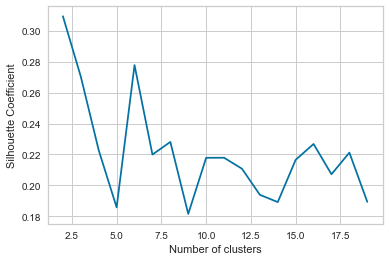

In [92]:
k_range = range(2,20)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(data_scaled_ave_clean)
    scores.append(silhouette_score(data_scaled_ave_clean, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

Generate training and testing groups

In [93]:
X = data_scaled_ave_clean
y = df_classes_clean

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=1234)

In [94]:
y_test

7     1
10    1
4     1
1     1
26    0
8     1
3     1
23    0
14    0
13    0
Name: Group, dtype: int64

Null accuracy

In [63]:
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_train)
print("Most frequent class dummy classifier test accuracy: ", accuracy_score(y_train, y_dumb_class))
scores = cross_val_score(dumb_model, X, y, cv=10, scoring='accuracy')
print(scores.mean())

Most frequent class dummy classifier test accuracy:  0.7272727272727273


NameError: name 'y' is not defined

Logistic regression

In [96]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train,y_train)
y_pred_class = logreg.predict(X_test)
print("Test set accuracy of logistic regression model: ", accuracy_score(y_test, y_pred_class))
scores = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
print(scores.mean())

Test set accuracy of logistic regression model:  0.6
0.7583333333333333


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

In [97]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
cm

array([[3, 1],
       [3, 3]], dtype=int64)

KNN

In [98]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train,y_train)

print ("scaled test accuracy:", accuracy_score(y_test,
                                                       knn.predict(X_test)))

scaled test accuracy: 0.5


In [99]:
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.6


Random Forest classifier

In [100]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rf.fit(X_train,y_train)

print ("scaled test accuracy:", accuracy_score(y_test,
                                                       rf.predict(X_test)))

scores = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
print(scores.mean())


# Actual class predictions
rf_predictions = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

scaled test accuracy: 0.5
0.675


In [101]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.75

In [102]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
1,act_ave,0.537980
2,actto_ave,0.137251
3,inact_ave,0.108506
5,lat1np_ave,0.097261
0,tl,0.069283
4,inactto_ave,0.049718


In [ ]:
# use GridSearchCV to automate the search across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,random_state=1,n_jobs=-1) #50 trees
max_depth_range = range(1, 20)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)
grid = GridSearchCV(rf_grid, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

# store the results of the grid search
grid.grid_scores_
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]

In [ ]:
# plot the results
plt.plot(max_depth_range, grid_mean_scores)
plt.xlabel('Value of max_depth')
plt.ylabel('Cross-Validated Mean Accuracy')

In [ ]:
# what was best model?
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
# try max_depth=2
rf_2 = RandomForestClassifier(max_depth=2, random_state=1)
print("Cross-validated mean accuracy for depth 2:",cross_val_score(rf_2, X, y, cv=10, scoring='accuracy').mean())

In [ ]:
import xgboost as xgb

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

predicted_probs_rf = rf.predict_proba(X_test)
predictions_rf = rf.predict(X_test)

y_test_rf_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_rf,predictions_rf.reshape((predictions_rf.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_rf_df.head()

In [ ]:
# list of values to try for n_estimators
estimator_range = range(20, 500, 20)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

In [ ]:
# list of values to try for max_features
feature_range = range(1, len(feature_names_cem)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=220, bootstrap=True, 
                                  oob_score=True, max_features=feature, random_state=1234)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [ ]:
# compute feature importances
pd.DataFrame({'feature':feature_names, 'importance':rfreg_best.feature_importances_}).sort_values(by='importance',ascending=False)

Metrics

In [ ]:
print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))

In [ ]:
#generate lr model false positive and true positive rates
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, predicted_probs_lr[:,1])

#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [ ]:
visualizer = ROCAUC(lr)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()

In [ ]:
# calculate AUC for lr and rf
print("LR model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_lr[:,1]))
print("RF model AUC: ",metrics.roc_auc_score(y_test, predicted_probs_rf[:,1]))

In [ ]:
# histogram of predicted probabilities grouped by actual response value for LR
y_test_lr_df.class_1.hist(by= y_test_lr_df.actual, sharex=True, sharey=True)
#same for RF
y_test_rf_df.class_1.hist(by= y_test_rf_df.actual, sharex=True, sharey=True)

Different threshold for classifier than 0.5?

Cross validation

In [ ]:
cross_val_scores_20 = cross_val_score(rf,X,y,cv=20)
cross_val_scores_40 = cross_val_score(rf,X,y,cv=40)
cross_val_scores_50 = cross_val_score(rf,X,y,cv=50)

print ("Mean cv-accuracy, 20 folds:",np.mean(cross_val_scores_20))
print ("Std of cv-accuracy, 20 folds:",np.std(cross_val_scores_20))

print ("Mean cv-accuracy, 40 folds:",np.mean(cross_val_scores_40))
print ("Std of cv-accuracy, 40 folds:",np.std(cross_val_scores_40))

print ("Mean cv-accuracy, 50 folds:",np.mean(cross_val_scores_50))
print ("Std of cv-accuracy, 50 folds:",np.std(cross_val_scores_50))